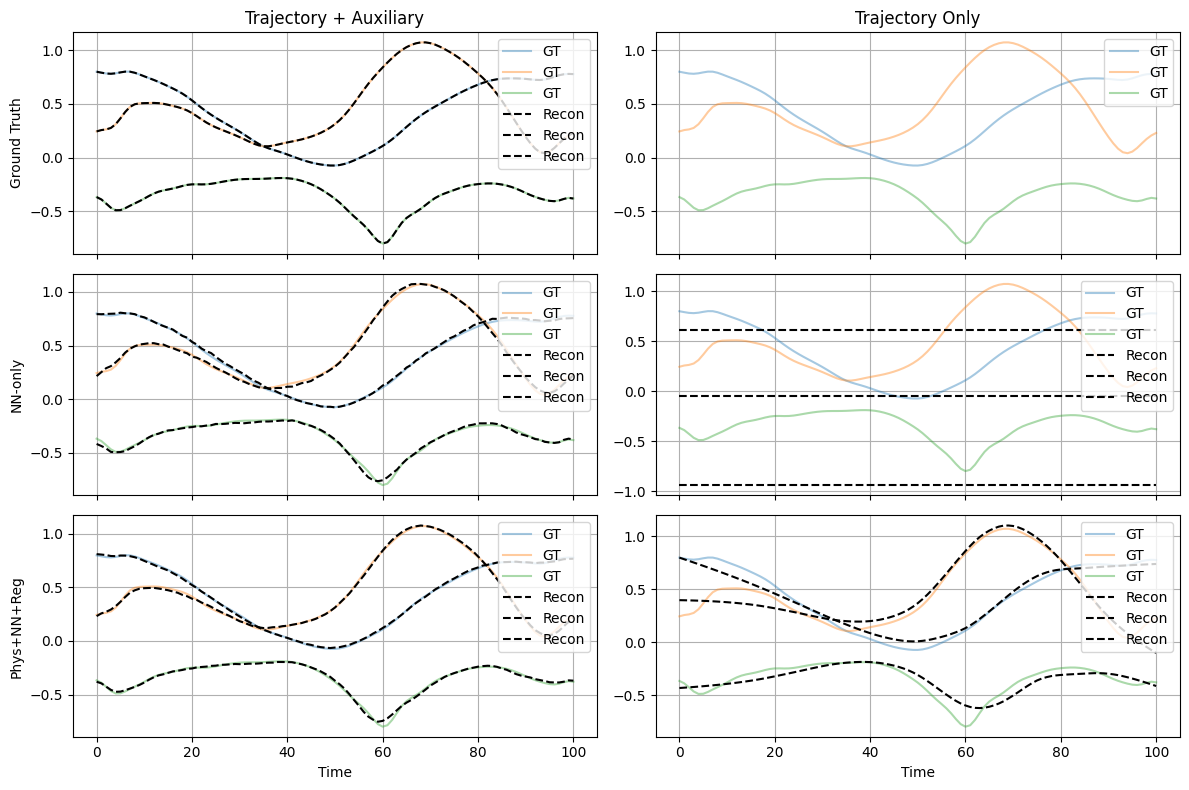

In [8]:
import json
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import torch
from physvae.locomotion.model import VAE
from torchdiffeq import odeint

# Settings
device = torch.device("cpu")
datadir = './data/locomotion/'
data_test = sio.loadmat(f'{datadir}/data_test_v5.mat')['data'].astype(np.float32)
_, dim_x, dim_t = data_test.shape
idx = 0  # sample to plot

# Define model variants
model_variants = {
    "Ground Truth": None,
    "NN-only": './out_locomotion_nnonly/',
    "Phys+NN+Reg": './out_locomotion_physnn/'
}

outputs = {}

# Inference
for label, modeldir in model_variants.items():
    if modeldir is None:
        outputs[label] = (data_test[idx].T, None)
        continue

    with open(f'{modeldir}/args.json', 'r') as f:
        args = json.load(f)
    model = VAE(args).to(device)
    model.load_state_dict(torch.load(f'{modeldir}/model.pt', map_location=device))
    model.eval()

    data_tensor = torch.tensor(data_test, dtype=torch.float32).to(device).contiguous()
    z_phy_stat, z_aux2_stat, init_yy = model.encode(data_tensor)
    z_phy, z_aux2 = model.draw(z_phy_stat, z_aux2_stat, hard_z=False)

    init_yy = init_yy[idx:idx+1].detach().clone().requires_grad_(True)
    x_PB, x_P, _, _ = model.decode(z_phy[idx:idx+1], z_aux2[idx:idx+1], init_yy, full=True)

    outputs[label] = (x_PB[0].detach().cpu().numpy().T, x_P[0].detach().cpu().numpy().T)


# Plot
fig, axs = plt.subplots(len(outputs), 2, figsize=(12, 8), sharex=True)

for i, (label, (pb, p)) in enumerate(outputs.items()):
    axs[i, 0].plot(data_test[idx].T, alpha=0.4, label='GT')
    if pb is not None:
        axs[i, 0].plot(pb, 'k--', label='Recon')
    axs[i, 0].set_ylabel(label)
    axs[i, 0].legend(loc='upper right')
    axs[i, 0].grid(True)

    axs[i, 1].plot(data_test[idx].T, alpha=0.4, label='GT')
    if p is not None:
        axs[i, 1].plot(p, 'k--', label='Recon')
    axs[i, 1].legend(loc='upper right')
    axs[i, 1].grid(True)

axs[0, 0].set_title("Trajectory + Auxiliary")
axs[0, 1].set_title("Trajectory Only")
axs[-1, 0].set_xlabel("Time")
axs[-1, 1].set_xlabel("Time")
plt.tight_layout()
plt.show()
